Автор: Лейман М.А.  
Дата создания: 06.04.2025  
# RF Regressor, Feature engineering

#### Описание набора данных:  

Признаки (столбцы):  
Возраст - __Age__ : Возраст застрахованного лица (числовой)  
Пол - __Gender__ : Пол застрахованного лица (Категория: Мужской, Женский)  
Годовой доход - __Annual Income__ : Годовой доход застрахованного лица (числовой, асимметричный)  
Семейное положение - __Marital Status__ : Семейное положение застрахованного лица (категория: холост, женат, разведен)  
Количество иждивенцев - __Number of Dependents__ : Количество иждивенцев (числовое, с пропущенными значениями)  
Уровень образования - __Education Level__ : наивысший достигнутый уровень образования (категория: средняя школа, бакалавр, магистр, доктор философии)  
Род занятий - __Occupation__ : Род занятий застрахованного лица (категория: работающий по найму, самозанятый, безработный)  
Оценка состояния здоровья - __Health Score__ : оценка, отражающая состояние здоровья (числовая, асимметричная)  
Местоположение - __Location__ : Тип местоположения (Категория: Город, Пригород, Сельская местность)  
Тип полиса - __Policy Type__ : Тип страхового полиса (Категорийный: Базовый, Комплексный, Премиум)  
Предыдущие заявления - __Previous Claims__ : Количество предыдущих заявлений (числовое, с выбросами)  
Возраст транспортного средства - __Vehicle Age__ : Возраст застрахованного транспортного средства (числовой)  
Кредитный рейтинг - __Credit Score__ : кредитный рейтинг застрахованного лица (числовой, с отсутствующими значениями)  
Срок действия страхового полиса - __Insurance Duration__ : Срок действия страхового полиса (числовой, в годах)  
Дата начала действия полиса - __Policy Start Date__ : Дата начала действия страхового полиса (Текст, неправильно отформатирован)  
Отзывы клиентов - __Customer Feedback__ : краткие отзывы клиентов (текст)  
Статус курения  - __Smoking Status__  : Статус курения застрахованного лица (Категория: Да, Нет)  
Частота упражнений - __Exercise Frequency__ : Частота упражнений (Категория: Ежедневно, Еженедельно, Ежемесячно, Редко)  
Тип недвижимости  - __Property Type__ : Тип собственности (Категория: Дом, Квартира, Кондоминиум)  

Целевая переменная:  
Сумма страховой премии - __Premium Amount__ : целевая переменная, представляющая сумму страховой премии (числовая, асимметричная)  

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import time
from glob import glob
import os 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures

import featuretools as ft

print('Виртуальное окружение')
!which python 
# Текущее положение
print('\nТекущее положение: ')
path_1 = os.getcwd()
print(path_1)

Виртуальное окружение
/home/maksim/anaconda3/envs/rapids-25.02/bin/python

Текущее положение: 
/home/maksim/develops/python/MAKSIM/ML/15_RF Regressor_Feature_engineering


In [ ]:

def handle_missing_values(data, threshold=35):
    """
    Обрабатывает пропущенные значения:
    - Удаляет столбцы, если пропусков > threshold%
    - 'Number of Dependents' → 0
    - 'Credit Score' → среднее значение
    - 'Property Type' → 'Apartment' (самая частая категория)
    - 'Property Type' → Кодируем: Apartment=0, Condo=1, House=2
    - Остальные числовые столбцы → медиана
    - Категориальные столбцы → мода
    """
    data = data.copy()

    # 1. Считаем процент пропусков в каждом столбце
    missing_percent = data.isnull().mean() * 100

    # 2. Удаляем столбцы, если пропусков > threshold%
    cols_to_drop = list(missing_percent[missing_percent > threshold].index)
    data.drop(columns=cols_to_drop, inplace=True)
    print(f"Удалены столбцы с более чем {threshold}% пропусков: {cols_to_drop}\n")

    # 3. Заполняем пропуски в "Number of Dependents" значением 0
    if "Number of Dependents" in data.columns:
        data["Number of Dependents"] = data["Number of Dependents"].fillna(0)
        print("Пропуски в 'Number of Dependents' заменены на 0.\n")

    # 4. Заполняем пропуски в "Credit Score" средним значением
    if "Credit Score" in data.columns:
        mean_credit_score = data["Credit Score"].mean()
        data["Credit Score"] = data["Credit Score"].fillna(mean_credit_score)
        print(f"Пропуски в 'Credit Score' заменены на среднее: {mean_credit_score:.2f}\n")

    # 5. Заполняем пропуски в "Property Type"
    if "Property Type" in data.columns:
        data["Property Type"] = data["Property Type"].fillna("House")
        print("Пропуски в 'Property Type' заменены на 'House'.\n")

        # Кодируем 'Property Type' в порядке возрастания
        property_mapping = {"Apartment": 0, "Condo": 1, "House": 2}
        data["Property Type"] = data["Property Type"].map(property_mapping)
        print("Столбец 'Property Type' закодирован: Apartment=0, Condo=1, House=2.\n")

    # 6. Заполняем оставшиеся числовые столбцы медианой
    numeric_columns = data.select_dtypes(include=[np.number]).drop(
        columns=["Number of Dependents", "Credit Score"], errors="ignore"
    )
    data[numeric_columns.columns] = numeric_columns.fillna(numeric_columns.median())

    # 7. Заполняем остальные категориальные столбцы модой
    categorical_columns = data.select_dtypes(exclude=[np.number])
    for col in categorical_columns.columns:
        data[col] = data[col].fillna(data[col].mode().iloc[0])

    return data


def encode_categorical_features(data):
    """
    Кодирует категориальные признаки:
    - Label Encoding для порядковых категорий (Education Level, Exercise Frequency, Policy Type, Location, Occupation)
    - One-Hot Encoding для номинальных категорий (Gender, Marital Status, Smoking Status)
    """

    # 1. Определяем категории
    ordinal_features = ["Education Level", "Exercise Frequency", "Policy Type", "Location", "Occupation"]  # Порядковые категории
    nominal_features = ["Gender", "Marital Status", "Smoking Status"]  # Номинальные категории

    # 2. Кодируем 'Policy Type' вручную
    policy_mapping = {"Basic": 0, "Comprehensive": 1, "Premium": 2}
    if "Policy Type" in data.columns:
        data["Policy Type"] = data["Policy Type"].map(policy_mapping)
        print("Столбец 'Policy Type' закодирован как:", policy_mapping)

    # 3. Кодируем 'Location' вручную
    location_mapping = {"Rural": 0, "Suburban": 1, "Urban": 2}
    if "Location" in data.columns:
        data["Location"] = data["Location"].map(location_mapping)
        print("Столбец 'Location' закодирован как:", location_mapping)

    # 4. Кодируем 'Occupation' вручную
    occupation_mapping = {"Unemployed": 0, "Self-Employed": 1, "Employed": 2}
    if "Occupation" in data.columns:
        data["Occupation"] = data["Occupation"].map(occupation_mapping)
        print("Столбец 'Occupation' закодирован как:", occupation_mapping)

    # 5. Label Encoding для остальных порядковых переменных
    label_encoders = {}
    for col in ordinal_features:
        if col in data.columns and col not in ["Policy Type", "Location", "Occupation"]:  # Эти уже закодированы вручную
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
            label_encoders[col] = le  # Сохраняем энкодер (для обратного преобразования)

    # 6. One-Hot Encoding для номинальных переменных
    data = pd.get_dummies(data, columns=nominal_features, drop_first=True)  # drop_first=True уменьшает размерность

    return data, label_encoders

def print_regression_metrics(y_true, y_pred, model_name="Модель"):
    print(f"\n Оценка качества для: {model_name}")
    print("MAE:", round(mean_absolute_error(y_true, y_pred), 4))
    print("MSE:", round(mean_squared_error(y_true, y_pred), 4))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_true, y_pred)), 4))
    print("R2:", round(r2_score(y_true, y_pred), 4))
    print("MAPE:", round(mean_absolute_percentage_error(y_true, y_pred) * 100, 2), "%")
    try:
        print("RMSLE:", round(np.sqrt(mean_squared_log_error(y_true, np.clip(y_pred, 0, None))), 4))
    except ValueError:
        print("RMSLE: ошибка (возможно, отрицательные значения)")


## 1 Загрузка

In [ ]:
train_df = pd.read_csv('dataset/train.csv')

train_df = train_df.drop(columns=["id"])

print('\nРазмер данных: ', train_df.shape)

print(train_df.head().to_string(index=False))

X = train_df.drop(columns=['Premium Amount'])
y = train_df['Premium Amount']
print("\nПропуски:")
train_df.isnull().sum()


Размер данных:  (1200000, 20)
 Age Gender  Annual Income Marital Status  Number of Dependents Education Level    Occupation  Health Score Location   Policy Type  Previous Claims  Vehicle Age  Credit Score  Insurance Duration          Policy Start Date Customer Feedback Smoking Status Exercise Frequency Property Type  Premium Amount
19.0 Female        10049.0        Married                   1.0      Bachelor's Self-Employed     22.598761    Urban       Premium              2.0         17.0         372.0                 5.0 2023-12-23 15:21:39.134960              Poor             No             Weekly         House          2869.0
39.0 Female        31678.0       Divorced                   3.0        Master's           NaN     15.569731    Rural Comprehensive              1.0         12.0         694.0                 2.0 2023-06-12 15:21:39.111551           Average            Yes            Monthly         House          1483.0
23.0   Male        25602.0       Divorced                

Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

# 2 Анализ

In [4]:
train_df

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.0,Female,27316.0,Married,0.0,Master's,Unemployed,13.772907,Urban,Premium,NaN,5.0,372.0,3.0,2023-05-03 15:21:39.257696,Poor,No,Daily,Apartment,1303.0
1199996,54.0,Male,35786.0,Divorced,NaN,Master's,Self-Employed,11.483482,Rural,Comprehensive,NaN,10.0,597.0,4.0,2022-09-10 15:21:39.134960,Poor,No,Weekly,Apartment,821.0
1199997,19.0,Male,51884.0,Divorced,0.0,Master's,NaN,14.724469,Suburban,Basic,0.0,19.0,NaN,6.0,2021-05-25 15:21:39.106582,Good,No,Monthly,Condo,371.0
1199998,55.0,Male,NaN,Single,1.0,PhD,NaN,18.547381,Suburban,Premium,1.0,7.0,407.0,4.0,2021-09-19 15:21:39.190215,Poor,No,Daily,Apartment,596.0


In [5]:
# Очистка от пропусков 
train_data_cleaned = handle_missing_values(train_df)
num_col_del = ['id']

# Закодируем категориальные столбцы
train_data_encoded, label_encoders = encode_categorical_features(train_data_cleaned)

print(train_data_encoded.head().to_string())

Удалены столбцы с более чем 35% пропусков: []

Пропуски в 'Number of Dependents' заменены на 0.

Пропуски в 'Credit Score' заменены на среднее: 592.92

Пропуски в 'Property Type' заменены на 'House'.

Столбец 'Property Type' закодирован: Apartment=0, Condo=1, House=2.

Столбец 'Policy Type' закодирован как: {'Basic': 0, 'Comprehensive': 1, 'Premium': 2}
Столбец 'Location' закодирован как: {'Rural': 0, 'Suburban': 1, 'Urban': 2}
Столбец 'Occupation' закодирован как: {'Unemployed': 0, 'Self-Employed': 1, 'Employed': 2}
    Age  Annual Income  Number of Dependents  Education Level  Occupation  Health Score  Location  Policy Type  Previous Claims  Vehicle Age  Credit Score  Insurance Duration           Policy Start Date Customer Feedback  Exercise Frequency  Property Type  Premium Amount  Gender_Male  Marital Status_Married  Marital Status_Single  Smoking Status_Yes
0  19.0        10049.0                   1.0                0           1     22.598761         2            2              2

In [6]:
train_data_encoded["Policy Start Date"] = pd.to_datetime(train_data_encoded["Policy Start Date"])

# Извлекаем только год
train_data_encoded["Policy Start Date"] = train_data_encoded["Policy Start Date"].dt.year  

# Сортируем список уникальных годов
unique_years = sorted(train_data_encoded["Policy Start Date"].unique())

# Создаём словарь для кодирования годов
year_mapping = {year: idx for idx, year in enumerate(unique_years)}

# Применяем замену
train_data_encoded["Policy Start Date"] = train_data_encoded["Policy Start Date"].map(year_mapping)

# Проверяем результат
print(train_data_encoded[["Policy Start Date"]].head())
print(f"Годы закодированы следующим образом: {year_mapping}")

# Определяем правильный порядок для категорий
feedback_mapping = {
    "Average": 1,
    "Good": 2,
    "Poor": 0
}

# Применяем mapping
train_data_encoded["Customer Feedback"] = train_data_encoded["Customer Feedback"].map(feedback_mapping)

# Проверяем результат
print(train_data_encoded["Customer Feedback"].head())


   Policy Start Date
0                  4
1                  4
2                  4
3                  5
4                  2
Годы закодированы следующим образом: {2019: 0, 2020: 1, 2021: 2, 2022: 3, 2023: 4, 2024: 5}
0    0
1    1
2    2
3    0
4    0
Name: Customer Feedback, dtype: int64


In [7]:
print(train_data_encoded.describe().to_string())

                Age  Annual Income  Number of Dependents  Education Level    Occupation  Health Score      Location   Policy Type  Previous Claims   Vehicle Age  Credit Score  Insurance Duration  Policy Start Date  Customer Feedback  Exercise Frequency  Property Type  Premium Amount
count  1.200000e+06   1.200000e+06          1.200000e+06     1.200000e+06  1.200000e+06  1.200000e+06  1.200000e+06  1.200000e+06     1.200000e+06  1.200000e+06  1.200000e+06        1.200000e+06       1.200000e+06       1.200000e+06        1.200000e+06   1.200000e+06    1.200000e+06
mean   4.114329e+01   3.241431e+04          1.826239e+00     1.506332e+00  1.303579e+00  2.555000e+01  9.971367e-01  1.002743e+00     1.001873e+00  9.569891e+00  5.929244e+02        5.018219e+00       2.620870e+00       9.943625e-01        1.514339e+00   1.000309e+00    1.102545e+03
std    1.343402e+01   3.161560e+04          1.469939e+00     1.123030e+00  8.199407e-01  1.182343e+01  8.157046e-01  8.166964e-01     8.203294e-01  

In [9]:
df = train_data_encoded.sample(n=10000, random_state=42).reset_index(drop=True) 
target_column = "Premium Amount"  

X = df.drop(columns=[target_column])
y = df[target_column]




## 4. Обучение модели БЕЗ генерации признаков

In [10]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_plain = RandomForestRegressor(n_estimators=100, random_state=42)
model_plain.fit(X_train, y_train)
y_pred_plain = model_plain.predict(X_test)

## 5. Оценка

In [11]:

print_regression_metrics(y_test, y_pred_plain, model_name="Random Forest")



 Оценка качества для: Random Forest
MAE: 684.1256
MSE: 786324.1815
RMSE: 886.7492
R2: -0.0024
MAPE: 321.42 %
RMSLE: 1.1888


## 6. Генерация признаков

In [ ]:
# Удаляем целевой признак из набора признаков
X = df.drop(columns=[target_column])
y = df[target_column]
# Проверим, что целевой признак удален
print(X.columns)

poly_transformer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

X_poly = poly_transformer.fit_transform(X)

X_poly = pd.DataFrame(X_poly, columns=poly_transformer.get_feature_names_out(X.columns))

print(X_poly.head())


Index(['Age', 'Annual Income', 'Number of Dependents', 'Education Level',
       'Occupation', 'Health Score', 'Location', 'Policy Type',
       'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration',
       'Policy Start Date', 'Customer Feedback', 'Exercise Frequency',
       'Property Type', 'Gender_Male', 'Marital Status_Married',
       'Marital Status_Single', 'Smoking Status_Yes'],
      dtype='object')
    Age  Annual Income  Number of Dependents  Education Level  Occupation  \
0  52.0         5538.0                   0.0              2.0         2.0   
1  60.0        39711.0                   4.0              0.0         2.0   
2  58.0         2364.0                   2.0              0.0         2.0   
3  39.0         9094.0                   0.0              0.0         2.0   
4  47.0        43189.0                   0.0              3.0         2.0   

   Health Score  Location  Policy Type  Previous Claims  Vehicle Age  ...  \
0      8.093145       0.0     

In [ ]:

poly_transformer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

df_poly = poly_transformer.fit_transform(X)

df_poly = pd.DataFrame(df_poly, columns=poly_transformer.get_feature_names_out(X.columns))

print(df_poly.head().to_string())


    Age  Annual Income  Number of Dependents  Education Level  Occupation  Health Score  Location  Policy Type  Previous Claims  Vehicle Age  Credit Score  Insurance Duration  Policy Start Date  Customer Feedback  Exercise Frequency  Property Type  Gender_Male  Marital Status_Married  Marital Status_Single  Smoking Status_Yes   Age^2  Age Annual Income  Age Number of Dependents  Age Education Level  Age Occupation  Age Health Score  Age Location  Age Policy Type  Age Previous Claims  Age Vehicle Age  Age Credit Score  Age Insurance Duration  Age Policy Start Date  Age Customer Feedback  Age Exercise Frequency  Age Property Type  Age Gender_Male  Age Marital Status_Married  Age Marital Status_Single  Age Smoking Status_Yes  Annual Income^2  Annual Income Number of Dependents  Annual Income Education Level  Annual Income Occupation  Annual Income Health Score  Annual Income Location  Annual Income Policy Type  Annual Income Previous Claims  Annual Income Vehicle Age  Annual Income Credit

## 7. Исключение столбцов с Nan

In [ ]:
# Удаление столбцов с NaN
df_poly = df_poly.dropna(axis=1, how="any")

# Удаление столбцов, где больше 90% значений равны 0
df_poly = df_poly.loc[:, (df_poly != 0).mean() > 0.1]

# Посмотрим на отфильтрованные данные
print(df_poly.head().to_string())

    Age  Annual Income  Number of Dependents  Education Level  Occupation  Health Score  Location  Policy Type  Previous Claims  Vehicle Age  Credit Score  Insurance Duration  Policy Start Date  Customer Feedback  Exercise Frequency  Property Type  Gender_Male  Marital Status_Married  Marital Status_Single  Smoking Status_Yes   Age^2  Age Annual Income  Age Number of Dependents  Age Education Level  Age Occupation  Age Health Score  Age Location  Age Policy Type  Age Previous Claims  Age Vehicle Age  Age Credit Score  Age Insurance Duration  Age Policy Start Date  Age Customer Feedback  Age Exercise Frequency  Age Property Type  Age Gender_Male  Age Marital Status_Married  Age Marital Status_Single  Age Smoking Status_Yes  Annual Income^2  Annual Income Number of Dependents  Annual Income Education Level  Annual Income Occupation  Annual Income Health Score  Annual Income Location  Annual Income Policy Type  Annual Income Previous Claims  Annual Income Vehicle Age  Annual Income Credit

## 8. Разделение датасета.

In [15]:
from sklearn.model_selection import train_test_split

y = df[target_column]

X = df_poly

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)


(8000, 229) (2000, 229)


## 9-10. Обучение и оценка

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R^2: {r2}")


MAE: 700.2432749999999
MSE: 811968.7150637499
R^2: -0.03509226518319797


In [ ]:
print_regression_metrics(y_test, y_pred, model_name="Random Forest  после генерации признаков")  


 Оценка качества для: Random Forest  после генерации признаков
MAE: 700.2433
MSE: 811968.7151
RMSE: 901.0931
R2: -0.0351
MAPE: 329.13 %
RMSLE: 1.2032


### Сравнение для 10000 строк

Оценка качества для: Random Forest  
MAE: 684.1256  
MSE: 786324.1815  
RMSE: 886.7492  
R2: -0.0024  
MAPE: 321.42 %  
RMSLE: 1.1888  



Оценка качества для: Random Forest  после генерации признаков  
MAE: 700.2433  
MSE: 811968.7151  
RMSE: 901.0931  
R2: -0.0351  
MAPE: 329.13 %  
RMSLE: 1.2032  




### Сравнение для 5000 строк

 Оценка качества для: Random Forest  
MAE: 665.2813  
MSE: 767820.8559  
RMSE: 876.2539  
R2: -0.0454  
MAPE: 286.3 %  
RMSLE: 1.1435  



 Оценка качества для: Random Forest  после генерации признаков  
MAE: 670.0734  
MSE: 778946.0911  
RMSE: 882.5792  
R2: -0.0605  
MAPE: 287.88 %  
RMSLE: 1.1519  

## 11. Важность признаков

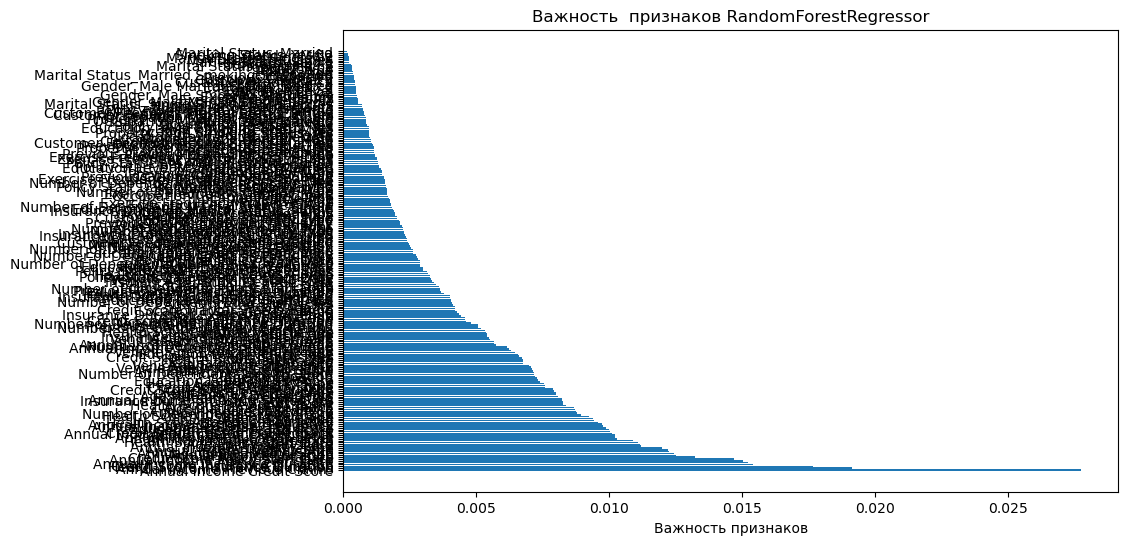

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Важность признаков
feature_importances = model.feature_importances_

# Сортируем важности по убыванию
indices = np.argsort(feature_importances)[::-1]

# Столбцы, отсортированные по важности
sorted_features = X_train.columns[indices]

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, feature_importances[indices])
plt.xlabel("Важность признаков")
plt.title(f"Важность  признаков RandomForestRegressor")
plt.show()


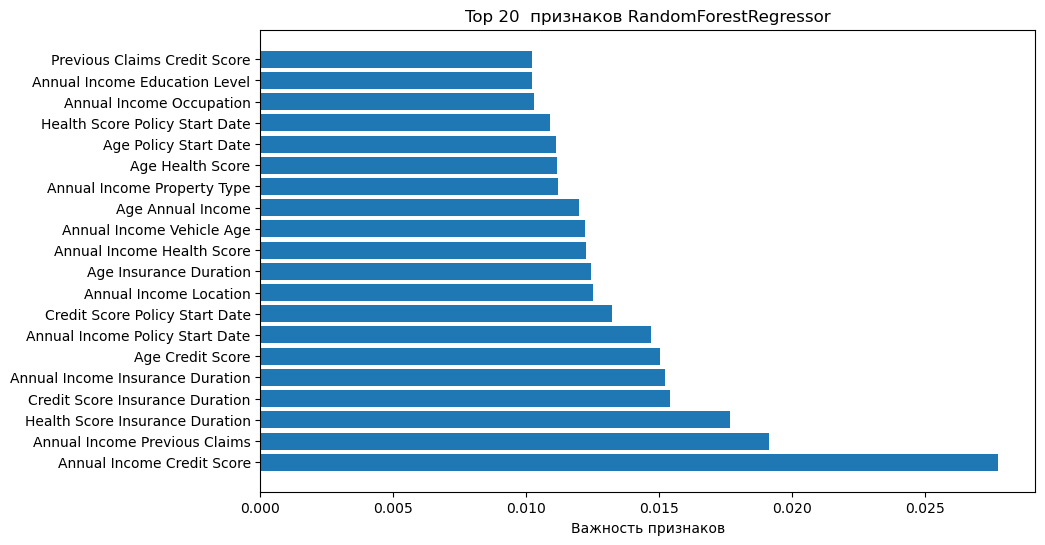

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Важность признаков
feature_importances = model.feature_importances_

# Сортируем важности по убыванию
indices = np.argsort(feature_importances)[::-1]

# Столбцы, отсортированные по важности
sorted_features = X_train.columns[indices]

# Выбираем только первые 20 признаков
top_n = 20
sorted_features_top = sorted_features[:top_n]
feature_importances_top = feature_importances[indices][:top_n]

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(sorted_features_top, feature_importances_top)
plt.xlabel("Важность признаков")
plt.title(f"Top {top_n}  признаков RandomForestRegressor")
plt.show()
